# Load data

In [1]:
import pandas as pd

In [2]:
from tqdm.auto import tqdm, trange
import random

In [3]:
labelled_data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

In [4]:
labelled_sents = set(labelled_data.ba)
print(len(labelled_sents))

157105


In [5]:
all_sents = []
with open('../../bashkort-spellchecker/data/clean_bk_sents.txt', 'r') as f:
    for line in tqdm(f):
        text = line.strip()
        if text not in labelled_sents:
            all_sents.append(text)

0it [00:00, ?it/s]

In [416]:
print(len(all_sents))

1602235


# Create a tokenizer

In [59]:
# I don't like BART tokenizer, because it is byte-level
# I don't like T5 tokenizer, because it uses crazy tokens
# from transformers import BartTokenizerFast, BartForConditionalGeneration, BartConfig
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5Config

In [62]:
old_tokenizer = T5TokenizerFast.from_pretrained('t5-small', model_max_length=512)

In [63]:
old_tokenizer('hello world')

{'input_ids': [21820, 296, 1], 'attention_mask': [1, 1, 1]}

In [64]:
def batch_iterator(batch_size=10000):
    for i in tqdm(range(0, len(all_sents), batch_size)):
        yield all_sents[i : i + batch_size]

In [65]:
tokenizer = old_tokenizer.train_new_from_iterator(text_iterator=batch_iterator(), vocab_size=32768)

  0%|          | 0/161 [00:00<?, ?it/s]

In [66]:
tokenizer

T5TokenizerFast(name_or_path='t5-small', vocab_size=32768, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_i

In [67]:
tokenizer('hello world')

{'input_ids': [5484, 19686, 5285, 2533, 12673, 14711, 5285, 4606, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [68]:
tokenizer.tokenize(random.choice(all_sents))

['▁Шағирә',
 'не',
 '▁балалары',
 ',',
 '▁туғандары',
 '▁һәм',
 '▁ауылдаштары',
 '▁ла',
 '▁ҡотланы',
 '.']

In [135]:
lens = pd.Series([len(tokenizer.tokenize(t)) for t in tqdm(random.sample(all_sents, 10000))])
lens.describe()

  0%|          | 0/10000 [00:00<?, ?it/s]

count    10000.000000
mean        18.311200
std         12.438136
min          2.000000
25%         10.000000
50%         15.000000
75%         23.000000
max        207.000000
dtype: float64

In [136]:
lens.quantile([0.9, 0.99, 0.999])

0.900     32.000
0.990     62.000
0.999    113.001
dtype: float64

# Initialize a model

In [278]:
cfg = T5Config(
    vocab_size=len(tokenizer),
    d_model=128,
    num_layers=3,
    num_heads=8,
    d_kv=16,
    d_ff=512,
    #feed_forward_proj='gated-gelu',
    decoder_start_token_id=tokenizer.pad_token_id,
)

In [279]:
cfg

T5Config {
  "d_ff": 512,
  "d_kv": 16,
  "d_model": 128,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 3,
  "num_heads": 8,
  "num_layers": 3,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 32768
}

In [280]:
model = T5ForConditionalGeneration(cfg)

In [281]:
tokenizer

T5TokenizerFast(name_or_path='t5-small', vocab_size=32768, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_i

In [282]:
MODEL_SAVE_PATH = '../models/t5-tiny-bak'

In [283]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../models/t5-tiny-bak\\tokenizer_config.json',
 '../models/t5-tiny-bak\\special_tokens_map.json',
 '../models/t5-tiny-bak\\tokenizer.json')

The 128\*3 model occupies only 22MB on disk, which is indeed extremely tiny. I hope it'll train super fast. 

# Define the training task

In [150]:
sent = random.choice(all_sents)
sent

'Мал көсө менән йәшәлә, балаларға ла ярҙам итәбеҙ, ҡыҙыбыҙҙы башлы-күҙле итергә кәрәк әле”, – ти улар.'

In [274]:
def fill_gap_task(text=None, min_sent_len=3, p_num_words=0.5, left_pad=0, right_pad=0, mask_token='<extra_id_0>'):
    if text is None:
        text = random.choice(all_sents)
    words = text.split()
    if len(words) < min_sent_len:
        return fill_gap_task()
    # to choose between all substrings uniformly, pick both ends uniformly and re-pick if the order is incorrect.
    left_id, right_id = 1, -1
    while left_id > right_id:
        left_id, right_id = [random.randint(left_pad, len(words)-1-right_pad) for _ in range(2)]
    #left_id = random.randint(left_pad, right_id)
    if random.random() > p_num_words:
        filler = [mask_token]
    else:
        filler = [mask_token.replace('0', str(right_id-left_id+1))]
    lhs = ' '.join(words[:left_id] + filler + words[right_id+1:])
    rhs = ' '.join(words[left_id:(right_id+1)])
    return lhs, rhs

In [275]:
from collections import Counter

for t in sorted([(x, y, c) for (x, y), c in Counter(fill_gap_task(text, p_num_words=0) for _ in range(10000)).most_common()]):
    print(t)

('<extra_id_0>', 'Быйылдан башлап аҡсалата премияның күләме лә арттырылды.', 361)
('<extra_id_0> арттырылды.', 'Быйылдан башлап аҡсалата премияның күләме лә', 372)
('<extra_id_0> аҡсалата премияның күләме лә арттырылды.', 'Быйылдан башлап', 381)
('<extra_id_0> башлап аҡсалата премияның күләме лә арттырылды.', 'Быйылдан', 359)
('<extra_id_0> күләме лә арттырылды.', 'Быйылдан башлап аҡсалата премияның', 378)
('<extra_id_0> лә арттырылды.', 'Быйылдан башлап аҡсалата премияның күләме', 344)
('<extra_id_0> премияның күләме лә арттырылды.', 'Быйылдан башлап аҡсалата', 360)
('Быйылдан <extra_id_0>', 'башлап аҡсалата премияның күләме лә арттырылды.', 345)
('Быйылдан <extra_id_0> арттырылды.', 'башлап аҡсалата премияның күләме лә', 384)
('Быйылдан <extra_id_0> аҡсалата премияның күләме лә арттырылды.', 'башлап', 334)
('Быйылдан <extra_id_0> күләме лә арттырылды.', 'башлап аҡсалата премияның', 331)
('Быйылдан <extra_id_0> лә арттырылды.', 'башлап аҡсалата премияның күләме', 357)
('Быйылдан <extr

# Training

In [284]:
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor, AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

import gc
import numpy as np

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [285]:
model.cuda();

In [286]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],  
    lr=1e-3,
    weight_decay=1e-3,
)

In [287]:
batch_size = 16 # we can get even more, but training gets slow
max_length = 128
warmup_steps = 5_000
training_steps = 500_000

In [288]:
losses = []

In [289]:
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [290]:
def get_batch_pairs(batch_size, p=0.2):
    xx, yy = [], []
    for text in random.sample(all_sents, batch_size):
        x, y = fill_gap_task(text, p_num_words=p)
        xx.append(x)
        yy.append(y)
    return xx, yy

In [291]:
get_batch_pairs(3)

(['Шулай <extra_id_0> райондаштарым, яҡын дуҫтарым килгәйне.',
  '– Алла Нур булғас, әҙәме НУР өсөн <extra_id_0> сыға.',
  'Йәй шифалы ҡымыҙ етештереп, малсылыҡта һәм үҫемлекселектә тир түккәндәргә <extra_id_0>'],
 ['уҡ мине яҡларға', 'ғүмер итә килеп', 'бирелә икән.'])

In [294]:
# optimizer.param_groups[0]['lr'] = 1e-3  # did this at about 43k step\s

In [417]:
model.train()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy = get_batch_pairs(batch_size)
    try:
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        
        loss = model(**x, labels=y.input_ids).loss

        loss.backward()
        losses.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy))
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 10000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/437518 [00:00<?, ?it/s]

63000 6.959281994819641
64000 6.951398554325103
65000 6.943892464160919
66000 6.960300998210907
67000 6.9240744976997375
68000 6.927171308517456
69000 6.932513535022736
70000 6.928753815174103
71000 6.921089878559113
72000 6.914636201858521
73000 6.894003620147705
74000 6.8857825021743775
75000 6.887303085327148
76000 6.8901493144035335
77000 6.866729349613189
78000 6.858011415958405
79000 6.8641417489051815
80000 6.868861122131348
81000 6.854151022911072
82000 6.835255885124207
83000 6.836852757453919
84000 6.821563381671906
85000 6.822126307964325
86000 6.83025892496109
87000 6.823637741565705
88000 6.801308063983917
89000 6.8094111852645876
90000 6.807211497306824
91000 6.8039093708992
92000 6.79197604894638
93000 6.794765630722046
94000 6.767387438774109
95000 6.764155313968659
96000 6.766629619598389
97000 6.77432412147522
98000 6.76506593465805
99000 6.7677820496559145
100000 6.762892932415008
101000 6.754883618354797
102000 6.7525999331474305
103000 6.745949672222137
104000 6.73

393000 6.149262020111084
394000 6.135114513874054
395000 6.1352773342132565
396000 6.131356385707855
397000 6.1178068060874935
398000 6.137139006614685
399000 6.114109637737275
400000 6.128445288658142
401000 6.1261354594230655
402000 6.12002006483078
403000 6.130353409767151
404000 6.135635453224182
405000 6.117773378849029
406000 6.115149351119995
407000 6.096954602718354
408000 6.092412299156189
409000 6.1176024699211125
410000 6.111249444007874
411000 6.110969156742096
412000 6.116384305000305
413000 6.096874368667603
414000 6.089506293296814
415000 6.10833524942398
416000 6.10795981502533
417000 6.098536083221435
418000 6.11706853055954
419000 6.089099063873291
420000 6.11169998550415
421000 6.093432714939118
422000 6.112754197120666
423000 6.088556210517884
424000 6.111444560527802
425000 6.106921851634979
426000 6.109640857219696
427000 6.096381187438965
428000 6.109571672439575
429000 6.084823582649231
430000 6.115287340164184
431000 6.097207271575928
432000 6.08801659822464
43

500000


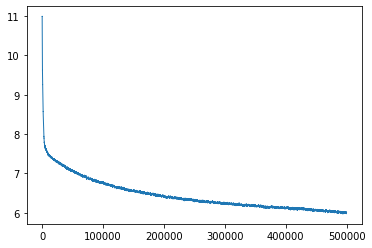

In [418]:
print(len(losses))
pd.Series(losses).ewm(300).mean()[10:].plot(lw=1);

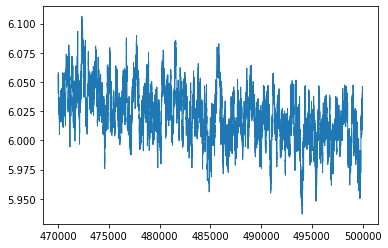

In [419]:
pd.Series(losses).ewm(100).mean()[-30000:].plot(lw=1);

In [429]:
sent = random.choice(all_sents)
sent

'Яңы исемдәр, яңы әҙәрҙәр, яңы ҡараш һәм яңы талаптар…'

In [430]:
xx, yy = fill_gap_task(sent, p_num_words=0.5)
print(xx)
print(yy)

Яңы исемдәр, яңы әҙәрҙәр, яңы ҡараш һәм яңы <extra_id_0>
талаптар…


In [431]:
model.train();

with torch.inference_mode():
    x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
    for _ in range(5):
        print(tokenizer.decode(model.generate(**x, num_beams=2, do_sample=True)[0]))

<pad> менән генә бергә нәҡ шундай уҡ ҙур рәхмәт ҡабул итә.</s>
<pad> уҡ ваҡытта ла, улар.</s>
<pad> өсөн.</s>
<pad> бер аҙ булһа, – тине ул.</s>
<pad> ғына түгел, ә мин үҙем дә...</s>


In [398]:
print(tokenizer.tokenize(xx))

['<extra_id_9>']
